In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#
# c - (x,y)^T of cone
# f - function determining variance along axis from car
# g - function determining variance perpendicular to axis from car
def sigma(c,f,g):
    c_orth = np.array([-c[1],c[0]])
    Q = np.stack((c,c_orth), axis=1)
    D = np.diag([f(c),g(c)])
    return Q@D@np.linalg.inv(Q)

def P_mahalanobis(a_sq):
    return 1-np.exp(-a_sq/2.0)

def a_sq_mahalanobis(P):
    return -2.0*np.log(1-P)

# The particle is within the ellipse xTS^{-1}x <= a_sq with probability P

S = sigma(np.array([2,0]),lambda x : np.linalg.norm(x), lambda x : np.linalg.norm(x)/6.0)

r = np.roots([1,0,0])
r = np.unique(r)
print(np.count_nonzero(np.isreal(r)))

1


Optimise line
p : [[-2]
 [-1]]
c : [[0]
 [1]]
d : [[-1]
 [ 0]]
Sigma : [[2 1]
 [1 1]]
Current gap : 5
Current gap : 2.5
Current gap : 1.25
Current gap : 0.625
Current gap : 0.3125
Current gap : 0.15625
Current gap : 0.078125
Current gap : 0.0390625
Current gap : 0.01953125
Final step : 0.322265625 of max 5
(10000,)


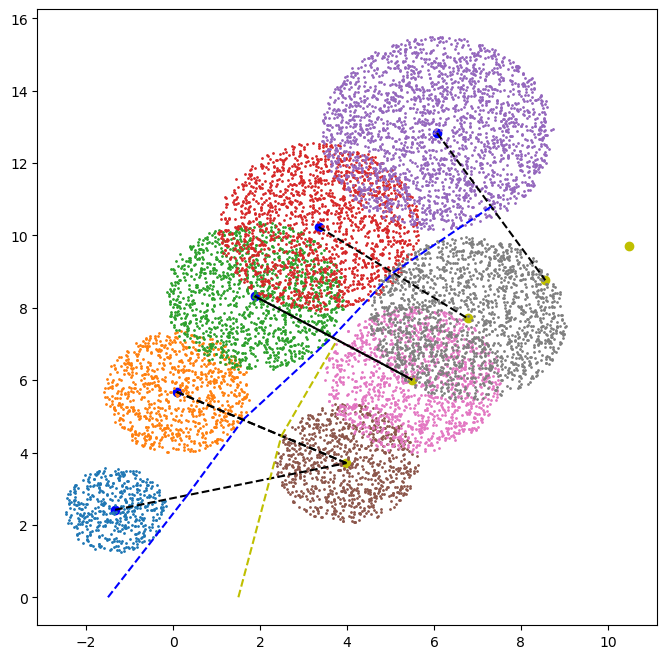

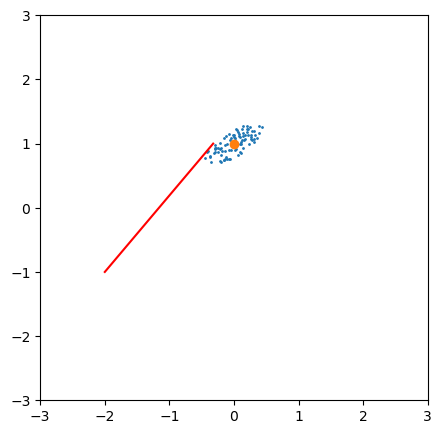

0:00:00.598073
Done
[[-1 -2]
 [ 0 -1]
 [ 1  0]]
1


In [30]:
def intersects(q_minus_p, Sigma_inv, pcT_Sigma_inv, pcT_Sigma_inv_pc, alpha):
    r = np.roots([(q_minus_p.T@Sigma_inv@q_minus_p)[0,0], 2*(pcT_Sigma_inv@q_minus_p)[0,0], pcT_Sigma_inv_pc[0,0]-alpha])
    r = np.unique(r)
    return (np.count_nonzero(np.isreal(r))>1),r

def optimize_ln(p,c,d,max_step, Sigma, alpha, verbose=False):
    if verbose:
        print("Optimise line")
        print("p : {}".format(p))
        print("c : {}".format(c))
        print("d : {}".format(d))
        print("Sigma : {}".format(Sigma))
    Sigma_inv = np.linalg.inv(Sigma)
    pc = p-c
    pcT_Sigma_inv = pc.T@Sigma_inv
    pcT_Sigma_inv_pc = pc.T@Sigma_inv@pc
    t0 = 0
    t1 = max_step
    roots = None
    threshold = 0.01
    while np.abs(t0-t1) > threshold:
        if verbose:
            print("Current gap : {}".format(np.abs(t0-t1)))
        t_m = 0.5*(t0+t1)
        q = c + d*t_m
        inter,r = intersects(q-p, Sigma_inv,pcT_Sigma_inv,pcT_Sigma_inv_pc, alpha)
        if inter:
            t0 = t_m
        else:
            t1 = t_m
            roots = r
    if verbose:
        print("Final step : {} of max {} roots {}".format(t1,max_step,roots))
    return c + d*t1

def optimize_ln2(p,c,d,max_step, Sigma, alpha, verbose=False):
    if verbose:
        print("Optimise line")
        print("p : {}".format(p))
        print("c : {}".format(c))
        print("d : {}".format(d))
        print("Sigma : {}".format(Sigma))
    Sigma_inv = np.linalg.inv(Sigma)
    t0 = 0
    t1 = max_step
    threshold = 0.01
    while np.abs(t0-t1) > threshold:
        if verbose:
            print("Current gap : {}".format(np.abs(t0-t1)))
        t_m = 0.5*(t0+t1)
        inter = ((d*t_m).T@Sigma_inv@(d*t_m))[0,0] < alpha
        if inter:
            t0 = t_m
        else:
            t1 = t_m
            roots = r
    if verbose:
        print("Final step : {} of max {}".format(t1,max_step))
    return c + d*t1

from datetime import datetime
startTime = datetime.now()

p = np.array([[-2,-1]]).T
c = np.array([[0,1]]).T
d = np.array([[-1,0]]).T
max_step = 5
Sigma = np.array([[2,1],[1,1]])
alpha = 0.1
q = optimize_ln2(p,c,d,max_step,Sigma, alpha, verbose=True)

X = (np.random.rand(10000,2)*-6+3)
X_minus_c = X - c.T
y = np.diag(X_minus_c@np.linalg.inv(Sigma)@X_minus_c.T)
print(y.shape)
in_ellipse = y < alpha

X = X[in_ellipse,:]
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1],s=1)
plt.plot([p[0],q[0]],[p[1],q[1]], c='r')
plt.scatter(c[0],c[1])
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

    
print(datetime.now()-startTime)
print("Done")

def closest(x,y,xx,yy):
    D = np.stack((xx-x,yy-y), axis=1)
    print(D)
    D = np.sum(D**2,axis=1)
    return np.argmin(D)

print(closest(1,2,np.array([0,1,2]), np.array([0,1,2])))

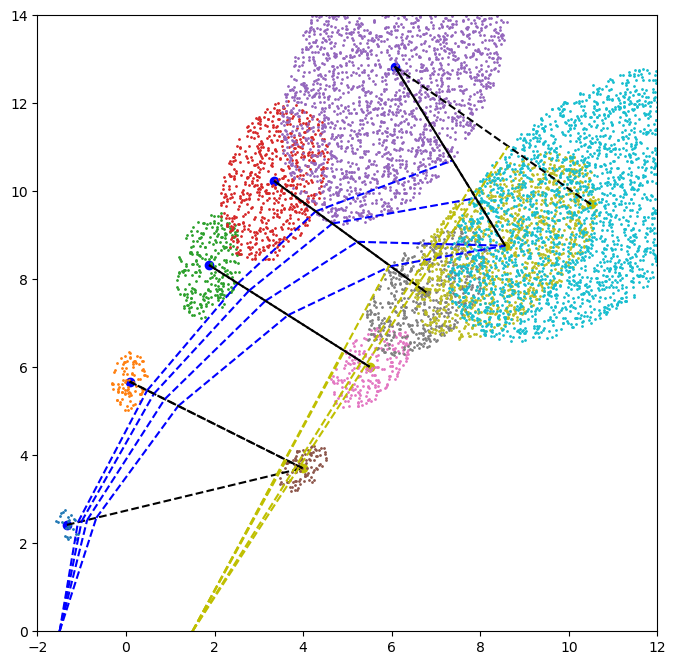

In [47]:
data = np.load("data.npy", allow_pickle=True)
B = np.zeros((len(data[0]),2))
Y = np.zeros((len(data[2]),2))

for i in range(len(data[0])):
    B[i,0] = data[0][i]
    B[i,1] = data[1][i]
for i in range(len(data[2])):
    Y[i,0] = data[2][i]
    Y[i,1] = data[3][i]
    
BY = np.vstack((B,Y))

def pdf(x,mu,Sigma):
    a = 1.0/(2*np.pi*np.sqrt(np.linalg.det(Sigma)))*np.exp(-(x-mu).T@np.linalg.inv(Sigma)@(x-mu)/2.0)
    return a[0,0]

def maha(x,mu,Sigma):
    a = (x-mu).T@np.linalg.inv(Sigma)@(x-mu)
    return a[0,0]
    
def compute_cone_pdf(c, BY,f=(lambda x : np.linalg.norm(x)),g=(lambda x : np.linalg.norm(x))):
    s = 0.0
    a = []
    for i in range(BY.shape[0]):
        S = sigma(BY[i],f,g)
        a.append(pdf(c,(BY[i].T)[:,None], S))
    return max(a)

def compute_cone_maha(c, BY,f=(lambda x : np.linalg.norm(x)),g=(lambda x : np.linalg.norm(x))):
    s = 0.0
    a = []
    for i in range(BY.shape[0]):
        S = sigma(BY[i],f,g)
        a.append(maha(c,(BY[i].T)[:,None], S))
    return max(a)

'''
D = 0.1
x_range = [-3,12]
y_range = [0,15]
Nx = int((x_range[1]-x_range[0])/D)
Ny = int((y_range[1]-y_range[0])/D)
Mx = np.zeros((Nx,Ny))
My = np.zeros((Nx,Ny))
hmap = np.zeros((Nx,Ny))
Sx = []
Sy = []
Sh = []
for i,x in enumerate(np.linspace(x_range[0],x_range[1],Nx)):
    for j,y in enumerate(np.linspace(x_range[0],x_range[1],Ny)):
        c = np.array([[x,y]]).T
        hmap[i,j] = compute_cone_pdf(c,BY)
        Mx[i,j] = x
        My[i,j] = y
        Sh.append(hmap[i,j])
        Sx.append(Mx[i,j])
        Sy.append(My[i,j])
        
plt.scatter(Sx,Sy,c=Sh)
plt.scatter(B[:,0],B[:,1],c='w')
plt.scatter(Y[:,0],Y[:,1],c='w')'''
'''
fig, ax = plt.subplots()
hmap = hmap[:-1, :-1]
z_min, z_max = -np.abs(hmap).max(), np.abs(hmap).max()
c = ax.pcolormesh(Mx, My, hmap, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)
'''
plt.show()

plt.figure(figsize=(8,8))
plt.scatter(B[:,0], B[:,1], c='b')
plt.scatter(Y[:,0], Y[:,1], c='y')

def sample_ellipse(c,Sigma,r,alpha):
    X = c + (2*r*np.random.rand(10000,2)-r)
    X_minus_c = X - c.T
    y = np.diag(X_minus_c@np.linalg.inv(Sigma)@X_minus_c.T)
    in_ellipse = y < alpha
    X = X[in_ellipse,:]
    plt.scatter(X[:,0], X[:,1],s=1)

def closest(p, pp):
    D = pp - p.T
    D = np.sum(D ** 2, axis=1)
    return np.argmin(D)

Bp = np.array([[-1.5,0.0]])
Yp = np.array([[1.5,0.0]])

def dot_blue_lane(alpha, sample=False):
    Bp = np.array([[-1.5,0.0]])
    for i in range(B.shape[0]):
        j = closest(B[i],Y)
        y = Y[j]
        SigmaB = sigma(B[i], lambda x : np.exp(0.4*np.linalg.norm(x)), lambda x : np.exp(0.4*np.linalg.norm(x))/3.0)
        if sample:
            sample_ellipse(B[i],SigmaB,5,alpha)
        new_Bp = optimize_ln2(Bp.T,B[i][:,None],(y-B[i])[:,None], 1.0, SigmaB, alpha, verbose=False).T
        if sample:
            plt.plot([B[i,0],Y[j,0]],[B[i,1],Y[j,1]],'k--')
        plt.plot([Bp[0,0],new_Bp[0,0]],[Bp[0,1],new_Bp[0,1]],'b--')
        Bp = new_Bp

dot_blue_lane(0.05, sample=True)
dot_blue_lane(0.1)
dot_blue_lane(0.2)
dot_blue_lane(0.4)

for i in range(Y.shape[0]):
    Yp = np.array([[1.5,0.0]])
    j = closest(Y[i],B)
    b = B[j]
    SigmaY = sigma(Y[i], lambda x : np.exp(0.4*np.linalg.norm(x)), lambda x : np.exp(0.4*np.linalg.norm(x))/3.0)
    alpha = 0.05
    sample_ellipse(Y[i],SigmaY,5,alpha)
    new_Yp = optimize_ln2(Yp.T,Y[i][:,None],(b-Y[i])[:,None], 1.0, SigmaY, alpha, verbose=False).T
    plt.plot([Y[i,0],B[j,0]],[Y[i,1],B[j,1]],'k--')
    plt.plot([Yp[0,0],new_Yp[0,0]],[Yp[0,1],new_Yp[0,1]],'y--')
    Yp = new_Yp

plt.xlim(-2,12)
plt.ylim(0,14)
plt.show()

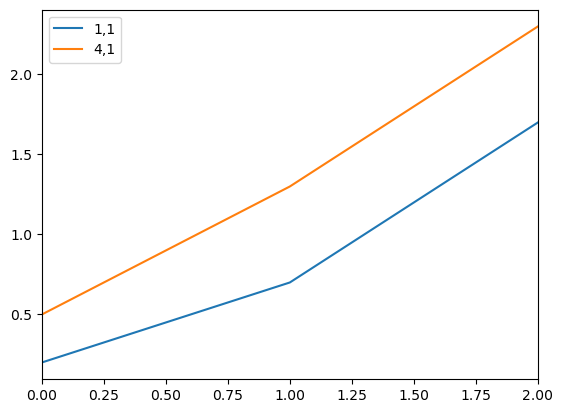

In [116]:
# C = np.array([[2,1],[2,0]])
v = np.linspace(0,1,3)
u = np.linspace(0.0,2.0,3)

U,V = np.meshgrid(u,v)
S = np.array([[1,0],[0,1]])
Sx = []
Sy = []
Sh = []

r = np.zeros((3))
for i,x in enumerate(u):
    b = []
    for j,y in enumerate(v):
        c = np.array([[x,y]]).T
        Sh.append(compute_cone_maha(c,C,lambda x : 1.0, lambda x : 1.0))
        b.append(Sh[-1])
        Sx.append(x)
        Sy.append(y)
    r[i] = 1.0/max(b)


b = [np.sum(r[:i+1]) for i in range(3)]
r = np.array(b)
plt.plot(u,r, label="1,1")

S = np.array([[1,0],[0,1]])
Sx = []
Sy = []
Sh = []

r = np.zeros((3))
for i,x in enumerate(u):
    b = []
    for j,y in enumerate(v):
        c = np.array([[x,y]]).T
        Sh.append(compute_cone_maha(c,C,lambda x : 4.0, lambda x : 1.0))
        b.append(Sh[-1])
        Sx.append(x)
        Sy.append(y)
    r[i] = 1.0/max(b)


b = [np.sum(r[:i+1]) for i in range(3)]
r = np.array(b)
plt.plot(u,r,label="4,1")

#plt.scatter(Sx,Sy,c=Sh)

plt.xlim((0,2))

#plt.ylim((0,1))
plt.legend()
plt.show()